In [7]:
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt
from boost_histogram import Histogram, axis
import boost_histogram.axis as bha

In [8]:
class Regular(bha.Regular):
    def __init__(self, bins, start, stop, *, name=None, underflow=True, overflow=True,
                growth=False, circular=False, transform=None):
        metadata = dict(name=name)
        super().__init__(bins, start, stop, metadata=metadata, underflow=underflow, 
                        overflow=overflow, growth=growth, circular=circular, transform=transform)
    @property
    def name(self):
        return self.metadata['name']
        
    @name.setter
    def name(self, value):
        self.metadata['name'] = value

In [9]:
class Variable(bha.Variable):
    def __init__(self, edges, *, name=None, underflow=True, overflow=True, growth=False):
        metadata = dict(name=name)
        super().__init__(edges, metadata=metadata, underflow=underflow,
                         overflow=overflow, growth=growth)
    @property
    def name(self):
        return self.metadata['name']
    
    @name.setter
    def name(self, value):
        self.metadata['name'] = value

In [10]:
class Integer(bha.Integer):
    def __init__(self, start, stop, *, name=None, underflow=True, overflow=True, growth=False):
        metadata = dict(name=name)
        super().__init__(start, stop, metadata=metadata, underflow=underflow, 
                         overflow=overflow, growth=growth)
    @property
    def name(self):
        return self.metadata['name']
    
    @name.setter
    def name(self, value):
        self.metadata['name'] = value

In [11]:
class StrCategory(bha.StrCategory):
    def __init__(self, categories, *, name=None, growth=False):
        metadata = dict(name=name)
        super().__init__(categories, metadata=metadata, growth=growth)
    @property
    def name(self):
        return self.metadata['name']
    
    @name.setter
    def name(self, value):
        self.metadata['name'] = value

In [12]:
class IntCategory(bha.IntCategory):
    def __init__(self, categories, *, name=None, growth=False):
        metadata = dict(name=name)
        super().__init__(categories, metadata=metadata, growth=growth)
    @property
    def name(self):
        return self.metadata['name']
    
    @name.setter
    def name(self, value):
        self.metadata['name'] = value

In [81]:
class NamedHist(Histogram):
    def fill(self, *args, **kwargs):
        if len(args) != 0:
            if 'weight' in kwargs:
                Histogram.fill(self, *args, kwargs['weight'])
            else:
                Histogram.fill(self, *args)
        else:
            temp_list = list()
            for value in self.axes:
                temp_list.append(kwargs[value.name])
            if 'weight' not in kwargs:
                kwargs['weight'] = None
            Histogram.fill(self, *temp_list, weight=kwargs['weight'])
    
    def __getitem__(self, index):
        if type(index) != dict:
            return Histogram.__getitem__(self, index)
        else:
            if set(map(type, index)) == {int}:
                return Histogram.__getitem__(self, index)
            else:
                temp_list = index.keys()
                temp_dict = dict()
                for ind, value in enumerate(self.axes):
                    if value.name in temp_list:
                        temp_dict[ind] = index[value.name]
                return Histogram.__getitem__(self, temp_dict)
            
    def pull_plot(self, callable, *, ax=None, pull_ax=None, style='seaborn-deep', figsize=(6, 8), save_fig=None):
        values = pdf(*self.axes.centers)*self.sum()*self.axes[0].widths
        yerr = np.sqrt(self.view())
        pulls = (self.view() - values) / yerr
        if ax is None and pull_ax is None:
            fig, (ax, pull_ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize)
        elif ax is None or pull_ax is None:
            print('Please enter both the axes or none of them!')
            return None, None
        ax.errorbar(self.axes[0].centers, values);
        ax.scatter(self.axes[0].centers, self.view(), s=self.view(), marker='|');
        ax.scatter(self.axes[0].centers, self.view(), s=10, marker='D', color='orange')
        ax.set_xlabel('x[units]')
        ax.set_ylabel('Counts')
        pull_ax.bar(self.axes[0].centers, pulls, width=self.axes[0].widths);
        seaborn.despine(ax=pull_ax, offset=10, trim=True)
        pull_ax.set_xlabel('x[units]')
        pull_ax.set_ylabel('Pulls')
        for i in range(1, 4):
            pull_ax.axhspan(-i, i, color='b', alpha=0.05)
        plt.style.use(style)
        fig.tight_layout()
        if save_fig is not None:
            fig.savefig(save_fig + '.png')
        plt.show()
        return ax, pull_ax

In [63]:
class Bool(Integer):
    def __init__(self, name=None):
        super().__init__(0, 2, name=name, overflow=False)

In [52]:
# Data generation

import numpy as np

# Random numbers from -1 to 1
x,y = np.random.random_sample([2, 1_000_000])*2 - 1

# Only hits inside radius 1 are "valid"
valid = (x**2 + y**2) < 1

In [53]:
h = NamedHist(
    Regular(10, -1, 1, name="x"),
    Regular(10, -1, 1, name="y"),
    Bool(name="valid"),
)

h.fill(x=x, y=y, valid=valid)

valid_and_invalid = h[{'valid': slice(None, None, bh.sum)}]

In [54]:
valid_and_invalid

NamedHist(
  Regular(10, -1, 1, metadata={'name': 'x'}),
  Regular(10, -1, 1, metadata={'name': 'y'}),
  storage=Double()) # Sum: 1000000.0

In [36]:
h = NamedHist(axis.Regular(10, 0, 1))
h.fill([0.35, 0.35, 0.45])
assert h[2] == 0
assert h[3] == 2
assert h[4] == 1
assert h[5] == 0

In [39]:
h = NamedHist(Regular(10, 0, 1, name="x"))  # NamedHist should require axis.Regular to have a name set
h.fill([0.35, 0.35, 0.45])  # Fill should be keyword only, with the names
# Optional if you want these to fail
assert h[2] == 0
assert h[3] == 2
assert h[4] == 1
assert h[5] == 0

# Example of a test that should be made to pass:
assert h[{'x':2}] == 0 # Should work
assert h[{'x':3}] == 2 # Should work
assert h[{'x':4}] == 1 # Should work
assert h[{'x':5}] == 0 # Should work

In [40]:
#Note that in the above example both the referencing methods work

In [82]:
data = np.random.normal(size=10_000)
h = NamedHist(Regular(50, -3, 3))
h.fill(data)

def pdf(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-.5*x**2)

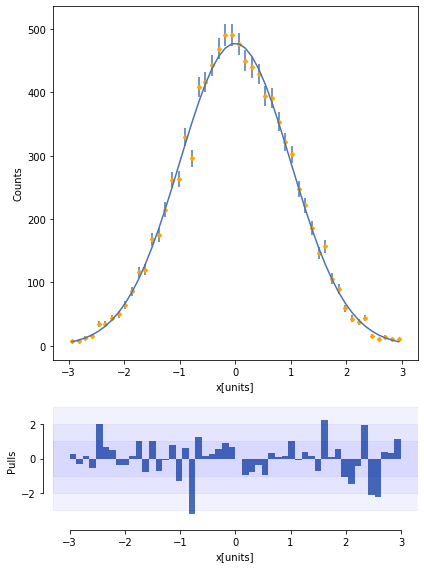

In [83]:
ax, pull_ax = h.pull_plot(pdf, save_fig='y')